## Cross isobath transport, time average, analysis notebook

For `8km_jra_ryf_obc_Charrassin` experiment (MOM6-CICE6 panan 1/12th degree ~ 4km with no ice shelves)

**Note** Several non-standard uses of `esm_datastore`:

- `esm_datastore` was generated with a different branch to main to pick up incorrectly named files (see https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/459, thanks to Charles Turner for fixing this for me)
- Years 9 and 10 of this run used parallelised IO, and unfortunately the tiling resulted in NaNs along part of the y axis in these files. Therefore, we must use a preprocessing function that replaces these axes with that of an earlier time (month 0) (thanks to Jemma Jeffree for her help with this!)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cm

In [2]:
client = Client(threads_per_worker = 1)
client.amm.start()
memory_limit=0
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36831,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42251,Total threads: 1
Dashboard: /proxy/43073/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:35667,


Load datastore

In [3]:
esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

Load month 0 specific datastore to get y axis info

In [4]:
mo0_esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/datastores/8km_jra_ryf_obc_Charrassin-output000/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

ds_good_yh = mo0_esm_datastore.search(variable="umo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yh_coords = ds_good_yh.yh.copy().load()
ds_good_yq = mo0_esm_datastore.search(variable="vmo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yq_coords = ds_good_yq.yq.copy().load()
def reset_y_coords(ds): #thanks to Jemma Jeffree for helping make this work!!
    ds = ds.assign_coords({'yh':good_yh_coords})
    ds = ds.assign_coords({'yq':good_yq_coords})
    return ds

When loading data that has a y-axis, you need to use the `preprocess` (and likely `decode_timedelta` too) arguments:
```
esm_datastore.search(variable="").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
```

In [27]:
'''
names of panant models
panant-01-zstar-ACCESSyr2
panant-005-zstar-ACCESSyr2
panant-0025-zstar-ACCESSyr2
'''
catalog = intake.cat.access_nri

density_slice = slice(1036.6,1038)

## Open panant-01-zstar-ACCESSyr2 data and process:

In [23]:
lat_slice = slice(-90,-59)
expt = 'panant-01-zstar-ACCESSyr2'

In [24]:
# open umo, vmo:

var_search = catalog[expt].search(variable='vmo', frequency="1mon")
dset = var_search.to_dask(xarray_open_kwargs={'decode_timedelta' : False})
darray = dset['vmo']
time_slice = np.arange(8*12,9*12+12)
vmo = darray.chunk(chunks={"time": -1}).isel(time=time_slice)

var_search = catalog[expt].search(variable='umo', frequency="1mon")
dset = var_search.to_dask(xarray_open_kwargs={'decode_timedelta' : False})
darray = dset['umo']
umo = darray.chunk(chunks={"time": -1}).isel(time=time_slice)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [25]:
# select latitude and density ranges, sum over density, annual averages:
vmo = vmo.sel(yq=lat_slice).sel(rho2_l=density_slice).mean('time')
vmo = vmo.isel(yq=slice(1, None))
umo = umo.sel(yh=lat_slice).sel(rho2_l=density_slice).mean('time')
umo = umo.isel(xq=slice(1, None))

In [9]:
# open contour data:
outfile = ('/g/data/g40/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz')
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yh = umo.yh
yq = vmo.yq
xh = vmo.xh
xq = umo.xq

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vmo, so like vmo this should have dimensions (yq, xh).
#       The x masks are used for umo, so like umo this should have dimensions (yh, xq).
#       However the actual name will always be simply y or x irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.
mask_x_transport = xr.DataArray(
    mask_x_transport, coords=[('y', yh.data), ('x', xq.data)])
mask_y_transport = xr.DataArray(
    mask_y_transport, coords=[('y', yq.data), ('x', xh.data)])
mask_x_transport_numbered = xr.DataArray(
    mask_x_transport_numbered, coords=[('y', yh.data), ('x', xq.data)])
mask_y_transport_numbered = xr.DataArray(
    mask_y_transport_numbered, coords=[('y', yq.data), ('x', xh.data)])

# number of points along contour:
num_points = int(np.maximum(
    np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y', 'x'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y', 'x'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [10]:
rho_0 = 1035.0

# Note that vmo is Ocean Mass Y Transport (kg s-1) and defined as the transport across
# the northern edge of a tracer cell so its coordinates should be (yq, xh).
# umo is Ocean Mass X Transport (kg s-1) and defined as the transport across
# the eastern edge of a tracer cell so its coordinates should be (yh, xq).
# However we will keep the actual name as simply y/x irrespective of the variable
# to make concatenation and sorting possible.
vmo = vmo.rename({'yq':'y', 'xh':'x'})
umo = umo.rename({'yh':'y', 'xq':'x'})

# convert kg/s to Sv and multiply by contour masks
vmo = (vmo/(1e6*rho_0)*mask_y_transport).compute()
umo = (umo/(1e6*rho_0)*mask_x_transport).compute()

# stack transports into 1d and drop any points not on contour:
x_transport_1d = umo.stack(contour_index=['y', 'x'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d = vmo.stack(contour_index=['y', 'x'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop=True)

# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim='contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour = vol_trans_across_contour.drop_vars({'x', 'contour_index', 'y'})
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = (vol_trans_across_contour.sum('contour_index')).compute()


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.23 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.23 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


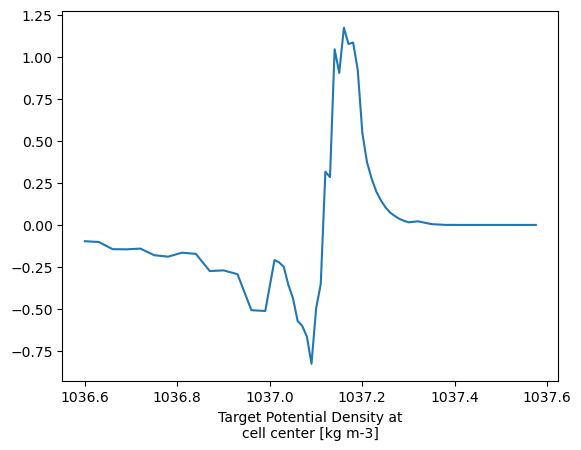

In [11]:
panan01_DSW_trans = vol_trans_across_contour.copy()
panan01_DSW_trans.plot()

save_dir = '/g/data/g40/akm157/model_data/mom6/panant-01-zstar-ACCESSyr2/cross_slope_transport_yr8_10.nc'

ds = xr.Dataset({'panan01_DSW_trans': panan01_DSW_trans})

ds.to_netcdf(save_dir)

## Open panant-005-zstar-ACCESSyr2 data and process:

In [29]:
lat_slice = slice(-90,-59)
expt = 'panant-005-zstar-ACCESSyr2'

In [30]:
# open umo, vmo:

chunks_dict = {
    'time' : -1,
    'rho2_l' : -1,
    'yh' : -1,
    'xq' : 3600,
    'yq' : -1,
    'xh' : 3600,
}

var_search = catalog[expt].search(variable='vmo', frequency="1mon")
dset = var_search.to_dask(xarray_open_kwargs={'chunks' : chunks_dict, 'decode_timedelta' : False})
darray = dset['vmo']
time_slice = np.arange(8*12,9*12+12)
vmo = darray.isel(time=time_slice)

var_search = catalog[expt].search(variable='umo', frequency="1mon")
dset = var_search.to_dask(xarray_open_kwargs={'chunks' : chunks_dict, 'decode_timedelta' : False})
darray = dset['umo']
umo = darray.isel(time=time_slice)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xq" starting at index 3600. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xq" starting at index 3600. This could degrade performance. Instead, consider rechunking after

In [31]:
# select latitude and density ranges, sum over density, annual averages:
vmo = vmo.sel(yq=lat_slice).sel(rho2_l=density_slice).mean('time')
vmo = vmo.isel(yq=slice(1, None))
umo = umo.sel(yh=lat_slice).sel(rho2_l=density_slice).mean('time')
umo = umo.isel(xq=slice(1, None))

In [32]:
# open contour data:
isobath_dir = ('/g/data/g40/akm157/model_data/mom6/panan/isobath_1000m_panan005.nc')

data = xr.open_dataset(isobath_dir)
mask_y_transport = data.mask_y_transport
mask_x_transport = data.mask_x_transport
mask_y_transport_numbered = data.mask_y_transport_numbered
mask_x_transport_numbered = data.mask_x_transport_numbered

yh = umo.yh
yq = vmo.yq
xh = vmo.xh
xq = umo.xq

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vmo, so like vmo this should have dimensions (yq, xh).
#       The x masks are used for umo, so like umo this should have dimensions (yh, xq).
#       However the actual name will always be simply y or x irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.
mask_x_transport = xr.DataArray(
    mask_x_transport.values, coords=[('y', yh.data), ('x', xq.data)])
mask_y_transport = xr.DataArray(
    mask_y_transport.values, coords=[('y', yq.data), ('x', xh.data)])
mask_x_transport_numbered = xr.DataArray(
    mask_x_transport_numbered.values, coords=[('y', yh.data), ('x', xq.data)])
mask_y_transport_numbered = xr.DataArray(
    mask_y_transport_numbered.values, coords=[('y', yq.data), ('x', xh.data)])

# number of points along contour:
num_points = int(np.maximum(
    np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y', 'x'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y', 'x'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [25]:
rho_0 = 1035.0

# Note that vmo is Ocean Mass Y Transport (kg s-1) and defined as the transport across
# the northern edge of a tracer cell so its coordinates should be (yq, xh).
# umo is Ocean Mass X Transport (kg s-1) and defined as the transport across
# the eastern edge of a tracer cell so its coordinates should be (yh, xq).
# However we will keep the actual name as simply y/x irrespective of the variable
# to make concatenation and sorting possible.
vmo = vmo.rename({'yq':'y', 'xh':'x'})
umo = umo.rename({'yh':'y', 'xq':'x'})

# convert kg/s to Sv and multiply by contour masks
vmo = (vmo/(1e6*rho_0)*mask_y_transport).compute()
umo = (umo/(1e6*rho_0)*mask_x_transport).compute()

# stack transports into 1d and drop any points not on contour:
x_transport_1d = umo.stack(contour_index=['y', 'x'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d = vmo.stack(contour_index=['y', 'x'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop=True)

# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim='contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour = vol_trans_across_contour.drop_vars({'x', 'contour_index', 'y'})
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = (vol_trans_across_contour.sum('contour_index')).compute()


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 28.43 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-09-01 09:40:34,962 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.14 GiB -- Worker memory limit: 4.47 GiB
2025-09-01 09:40:46,094 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.da

KilledWorker: Attempted to run task ('open_dataset-vmo-concatenate-cde1f4b1a40e1eb2bd7d4f42cef2e75c', 113, 0, 0, 1) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:42933. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [26]:
panan005_DSW_trans = vol_trans_across_contour.copy()
panan005_DSW_trans.plot()

save_dir = '/g/data/g40/akm157/model_data/mom6/panant-005-zstar-ACCESSyr2/cross_slope_transport_yr8_10.nc'

ds = xr.Dataset({'panan005_DSW_trans': panan005_DSW_trans})

ds.to_netcdf(save_dir)

NameError: name 'vol_trans_across_contour' is not defined

## Open 8km_jra_ryf_obc_Charrassin data and process:

In [28]:
lat_slice = slice(-90,-59)
expt = '8km_jra_ryf_obc_Charrassin'

In [29]:
# open umo, vmo:

chunks_dict = {
    'time' : -1,
    'rho2_l' : -1,
    'yh' : -1,
    'xq' : 1080,
    'yq' : -1,
    'xh' : 1080,
}
var_search = esm_datastore.search(variable='vmo', frequency="1mon")
dset = var_search.to_dask(preprocess=reset_y_coords, xarray_open_kwargs={'decode_timedelta':True})
darray = dset['vmo']
time_slice = np.arange(8*12,9*12+12)
vmo = darray.chunk(chunks={"time": -1}).isel(time=time_slice)

var_search = esm_datastore.search(variable='umo', frequency="1mon")
dset = var_search.to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})# 'chunks' : chunks_dict, 
darray = dset['umo']
umo = darray.chunk(chunks={"time": -1}).isel(time=time_slice)

In [8]:
# test smaller density range:
#density_slice = slice(1037.1,1037.4)

In [30]:
# select latitude and density ranges, sum over density, annual averages:
vmo = vmo.sel(yq=lat_slice).sel(rho2_l=density_slice).mean('time')
vmo = vmo.isel(yq=slice(1, None)).load()
umo = umo.sel(yh=lat_slice).sel(rho2_l=density_slice).mean('time')
umo = umo.isel(xq=slice(1, None)).load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 59.14 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 59.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [31]:
# open contour data:
isobath_dir = '/g/data/g40/akm157/model_data/mom6/8km_jra_ryf_obc_Charrassin/isobath_1000m_8km_jra_ryf_obc_Charrassin.nc'

data = xr.open_dataset(isobath_dir)
mask_y_transport = data.mask_y_transport
mask_x_transport = data.mask_x_transport
mask_y_transport_numbered = data.mask_y_transport_numbered
mask_x_transport_numbered = data.mask_x_transport_numbered

yh = umo.yh
yq = vmo.yq
xh = vmo.xh
xq = umo.xq

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vmo, so like vmo this should have dimensions (yq, xh).
#       The x masks are used for umo, so like umo this should have dimensions (yh, xq).
#       However the actual name will always be simply y or x irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.
mask_x_transport = xr.DataArray(
    mask_x_transport.values, coords=[('y', yh.data), ('x', xq.data)])
mask_y_transport = xr.DataArray(
    mask_y_transport.values, coords=[('y', yq.data), ('x', xh.data)])
mask_x_transport_numbered = xr.DataArray(
    mask_x_transport_numbered.values, coords=[('y', yh.data), ('x', xq.data)])
mask_y_transport_numbered = xr.DataArray(
    mask_y_transport_numbered.values, coords=[('y', yq.data), ('x', xh.data)])

# number of points along contour:
num_points = int(np.maximum(
    np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y', 'x'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y', 'x'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [32]:
rho_0 = 1035.0

# Note that vmo is Ocean Mass Y Transport (kg s-1) and defined as the transport across
# the northern edge of a tracer cell so its coordinates should be (yq, xh).
# umo is Ocean Mass X Transport (kg s-1) and defined as the transport across
# the eastern edge of a tracer cell so its coordinates should be (yh, xq).
# However we will keep the actual name as simply y/x irrespective of the variable
# to make concatenation and sorting possible.
vmo = vmo.rename({'yq':'y', 'xh':'x'})
umo = umo.rename({'yh':'y', 'xq':'x'})

# convert kg/s to Sv and multiply by contour masks
# does not work if do compute here:
vmo = (vmo/(1e6*rho_0)*mask_y_transport)#.compute()
umo = (umo/(1e6*rho_0)*mask_x_transport)#.compute()

# stack transports into 1d and drop any points not on contour:
x_transport_1d = umo.stack(contour_index=['y', 'x'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d = vmo.stack(contour_index=['y', 'x'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop=True)


In [33]:
# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim='contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour = vol_trans_across_contour.drop_vars({'x', 'contour_index', 'y'})
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = (vol_trans_across_contour.sum('contour_index')).compute()

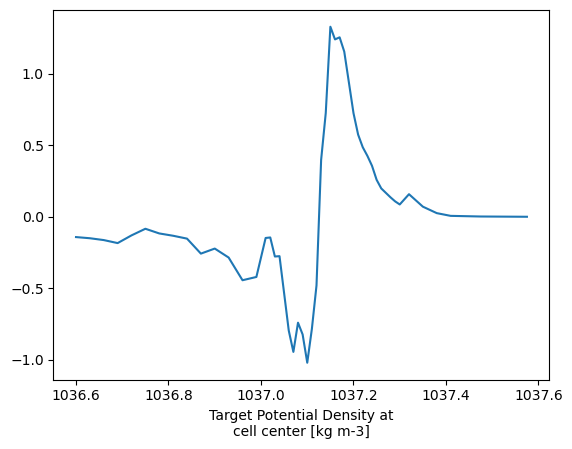

In [34]:
rOM3_DSW_trans = vol_trans_across_contour.copy()

rOM3_DSW_trans.plot()

save_dir = '/g/data/g40/akm157/model_data/mom6/8km_jra_ryf_obc_Charrassin/cross_slope_transport_yr8_10.nc'
ds = xr.Dataset({'rOM3_DSW_trans': rOM3_DSW_trans})

ds.to_netcdf(save_dir)

## Reopen all saved time-averaged transports and plot:

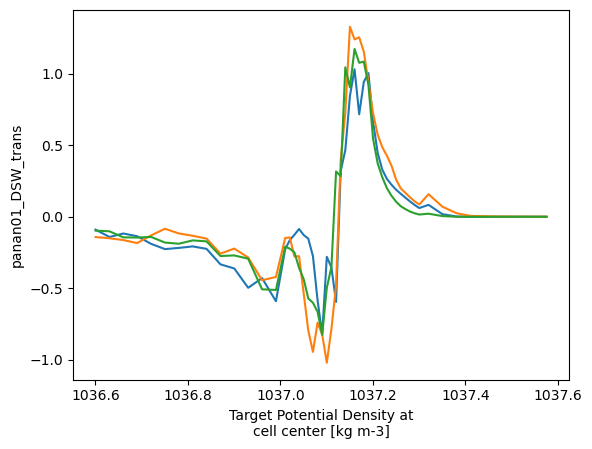

In [35]:
save_dir = '/g/data/g40/akm157/model_data/mom6/panant-005-zstar-ACCESSyr2/cross_slope_transport_yr8_10.nc'
data = xr.open_dataset(save_dir)
panan005_DSW_trans = data.panan005_DSW_trans
panan005_DSW_trans.plot()

save_dir = '/g/data/g40/akm157/model_data/mom6/8km_jra_ryf_obc_Charrassin/cross_slope_transport_yr8_10.nc'
data = xr.open_dataset(save_dir)
rOM3_DSW_trans = data.rOM3_DSW_trans
rOM3_DSW_trans.plot()

save_dir = '/g/data/g40/akm157/model_data/mom6/panant-01-zstar-ACCESSyr2/cross_slope_transport_yr8_10.nc'
data = xr.open_dataset(save_dir)
panan01_DSW_trans = data.panan01_DSW_trans
panan01_DSW_trans.plot()

(1037.4, 1036.6)

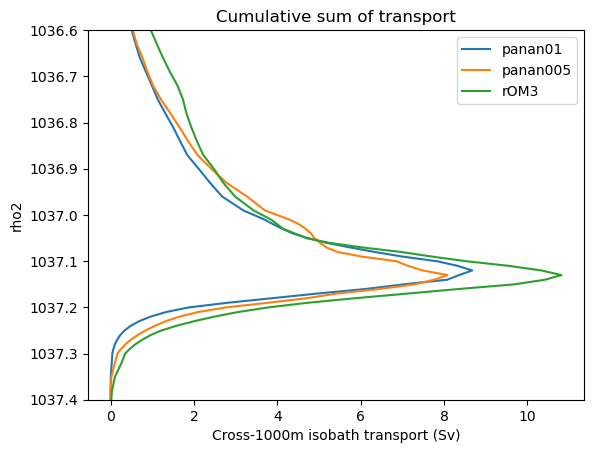

In [45]:
plt.plot(panan01_DSW_trans[::-1].cumsum()[::-1],panan01_DSW_trans.rho2_l,label='panan01')
plt.plot(panan005_DSW_trans[::-1].cumsum()[::-1],panan005_DSW_trans.rho2_l,label='panan005')
plt.plot(rOM3_DSW_trans[::-1].cumsum()[::-1],rOM3_DSW_trans.rho2_l,label='rOM3')
plt.legend()
#plt.xticks((0,5,10,15,20))
#plt.xlabel('Year')
plt.xlabel('Cross-1000m isobath transport (Sv)')
plt.title('Cumulative sum of transport')
plt.ylabel('rho2')
plt.ylim(1037.4,1036.6)